In [476]:
import numpy as np
import pickle
import pandas as pd
from functools import reduce

from environments.interface import InterfaceEnvironment

# Necessary Data
with open("..//data//fertility.pkl", "rb") as f:
    fertility_data = pickle.load(f)

with open("..//data//men_wage_path.pkl", "rb") as f:
    men_wage_path_data = pickle.load(f)

with open("..//data//men_hours_empirical", "rb") as f:
    men_hours_data = pickle.load(f)

dropout_prob_df = pd.read_pickle('..//data//dropout_prop.pkl')

def get_dropout_rate(x):
    try:
        v = float(dropout_prob_df['dropout_prop'].loc[dropout_prob_df.index == x])
        if v is not None:
            return v
        else:
            return 0.0
    except:
        return 0.0

# actually 1-dropout_prop 
dropout_prob = np.array(list(map(lambda x: get_dropout_rate(x), range(65))))
educ_start_prob = float(dropout_prob_df['y_true'].loc[dropout_prob_df.index == 18])

men_salary_path = np.array(men_hours_data * men_wage_path_data)

# calculating scales
Q_mean, Q_scale = (60 + 18) * 0.5, (60 - 18) * 0.5
K_mean, K_scale = (0 + 5) * 0.5, (5 - 0) * 0.5
G_mean, G_scale = (0 + 5) * 0.5, (5 - 0) * 0.5
Z_mean, Z_scale = (-200 + 200), (200 - (-200)) * 0.5
B_mean, B_scale = np.ones(4) * 0, np.ones(4) * 1
C_mean, C_scale = np.ones(4) * 8, np.ones(4) * 8
E_prob_mean, E_prob_scale = 0.0, 1.0 
E_mean, E_scale = 0.0, 1.0

beta_K_mean, beta_K_scale = (-5 + 5) * 0.5, (5 - (-5)) * 0.5
beta_L_mean, beta_L_scale = (-5 + 5) * 0.5, (5 - (-5)) * 0.5


def scale_states(Q, G, K, Z, beta_K, beta_L):
    Q = (Q - Q_mean) / Q_scale
    G = (G - G_mean) / G_scale
    K = (K - K_mean) / K_scale
    Z = (Z - Z_mean) / Z_scale

    beta_K = (beta_K - beta_K_mean) / beta_K_scale
    beta_L = (beta_L - beta_L_mean) / beta_L_scale
    return np.array([Q, G, K, Z, beta_K, beta_L])


ACTIONS = [0, 15, 25, 37]


STATES_MU2 = np.concatenate( \
        [np.array([Q_mean, G_mean, K_mean, Z_mean, beta_L_mean, E_prob_mean, E_mean]),B_mean, C_mean]) 

STATES_SIGMA2 = np.concatenate(\
        [np.array([Q_scale, G_scale, K_scale, Z_scale, beta_L_scale, E_prob_scale, E_scale]), B_scale, C_scale])


def translate_action_model2(a):
    return ACTIONS[a]


# values for reward scaler is found by tuning parameters so r_scaled in [-1, 1]
def reward_scaler_model2(r, beta_L):
    return ((r - beta_L * 11.8)  - 121) / 6


class EnvironmentModel2(InterfaceEnvironment):

    """
    Ordering of items
    states: Q, M, K, W
    shocks: epsilon, rho, psi
    """

    DEFAULT_Q = 18
    DEFAULT_G = 2.0
    DEFAULT_K = 0
    DEFAULT_Z = 0.0
    DEFAULT_B = np.zeros(4)
    DEFAULT_C = np.zeros(4)
    DEFAULT_E = 1
    DEFAULT_E_prob = dropout_prob[18] 

    def __init__(
        self, sigma_epsilon, S_min, eta_G, eta_G_sq, alpha, delta, beta_L, zeta
    ):

        # parameters
        self.sigma_epsilon = sigma_epsilon
        self.S_min = S_min
        self.eta_G = eta_G
        self.eta_G_sq = eta_G_sq
        self.alpha = alpha
        self.delta = delta
        self.zeta = zeta
        
        # The parameters that need to be tuned!
        self.beta_L = beta_L

        # states
        self.Q = self.DEFAULT_Q
        self.G = self.DEFAULT_G
        self.K = self.DEFAULT_K
        self.Z = self.DEFAULT_Z
        self.E = self.DEFAULT_E
        self.E_prob = self.DEFAULT_E_prob
        self.B = self.DEFAULT_B
        self.C = self.DEFAULT_C


    def __repr__(self):
        return f"(Q: {self.Q}, G: {self.G}, K: {self.K}, Z: {self.Z})"

    @property
    def states(self):
        array = np.array([self.Q, self.G, self.K, self.Z, self.beta_L, self.E_prob, self.E])
        return np.concatenate([array, self.B, self.C])
        
    def reset(self, states=None, parameters=None):
        """Expect states given as: (Q, G, K, Z, B, C) """
        if states is not None:
            Q, G, K, Z, E_prob, E, B, C = states[0], states[1], states[2], states[3], states[4], states[5]
            self.Q = Q
            self.G = G
            self.K = K
            self.Z = Z
            self.E_prob = E_prob
            self.E = E 
            self.B = B
            self.C = C
        else:
            self.Q = self.DEFAULT_Q
            self.G = self.DEFAULT_G
            self.K = self.DEFAULT_K
            self.Z = self.DEFAULT_Z
            self.E = self.DEFAULT_E * np.random.binomial(1, p=educ_start_prob) # weird implementaion due to randomness
            self.E_prob = self.DEFAULT_E_prob
            self.B = self.DEFAULT_B
            self.C = self.DEFAULT_C

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)

        return self.states

    def step(self, action, shocks=None, parameters=None):
        """
        shocks:
            (epsilon, psi) <- that order

        returns:
            (state, reward, done, info)
        """
        if shocks is None:
            shocks = self.draw_shocks()
        epsilon, psi = shocks

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)
        # remember action: hours (H)

        ### transition
        self.calc_Q()
        self.calc_E()
        self.calc_E_prob()
        self.calc_Z(epsilon)
        self.calc_K(psi)
        self.calc_B()
        self.calc_C()

        ### model dynamic
        transfer = self.calc_transfer()
        J = self.calc_J()
        L = self.calc_L(action, J)

        # wage/salary process
        log_S_tilde = self.calc_log_S_tilde()
        S = self.calc_S(log_S_tilde)
        W = self.calc_W(S, action)

        # husband income
        M = self.calc_M()

        # household income
        Y = self.calc_Y(W, M, transfer)

        utility = self.calc_U(L, Y)

        self.calc_G(action)

        # this might be changed
        done = self.calc_stops()

        _info = {'Y': Y, 'L': L, 'W': W, 'S': S, 'M': M, 'J': J, 'Q': self.Q, 'transfer': transfer}
        
        if done is True:
            return self.states, utility, True, _info

        return self.states, utility, False, _info
    
    def calc_E(self):
        if self.E < 0.5:
            pass
        else:
            _dropout = np.random.binomial(1, self.E_prob)
            self.E = self.E * _dropout
            
    def calc_E_prob(self):
        self.E_prob = dropout_prob[self.Q]
        

    # model dynamic
    def calc_log_S_tilde(self):
        return self.alpha + self.eta_G * self.G + self.eta_G_sq * self.G ** 2

    def calc_U(self, L, Y):
        u = self.beta_L * L**self.zeta  + Y**self.zeta
        if np.isnan(u):
            raise Exception(f"K: {self.K}, L: {L}, Y: {Y}")
        return u

    def calc_W(self, S, H):
        return S * H

    def calc_M(self):
        # use data (non parametric)
        # return 450000
        try:
            return men_salary_path[self.Q]
        except:
            return men_salary_path[int(self.Q)]

    def calc_Y(self, W, M, transfer):
        return W + M + transfer

    @staticmethod
    def calc_child_work_hours(child_age):
        hours = 0
        if child_age < 3:
            hours = 10
        if 2 < child_age < 16:
            hours = 3.5
        return hours
    
    def calc_J(self):
        child_hours_ = np.array(tuple(map(self.calc_child_work_hours, self.C)))
        child_hours = child_hours_ * self.B
        total_hours = np.sum(child_hours)
        return total_hours
    
    def cap_child_age(C):
        # max age=18, when age > 18, it caps the age at 18
        return C * (C <= 18) * np.ones(4) + (C > 18) * 18
        
    def calc_C(self):
        self.C = self.C + self.B
        return self.C
        
    def calc_B(self):
        B = np.zeros(4)
        B[0:self.K] = 1
        self.B = B
        return self.B
    
    def calc_transfer(self):
        """SU: 6000 * 12 / 52 = 1400"""
        if self.E > 0.5:
            return 1400
        else:
            return 0
        
    def calc_L(self, hours, J):
        return (7 * 24 - hours - J - self.E*37)

    def calc_stops(self):
        # stops the model (returns done flag)
        if self.Q > 60:
            return True
        return False

    def calc_K(self, psi):
        if self.K < 5:
            self.K = self.K + psi

    def calc_S(self, log_S_tilde):
        _S = np.exp(log_S_tilde) + self.Z
        return max(self.S_min, _S)
        # return 190

    def calc_Q(self):
        self.Q = self.Q + 1

    def calc_G(self, H):
        self.G = self.G * (1 - self.delta) + H / 37

    def calc_Z(self, epsilon):
        self.Z = self.Z + epsilon

    # def shocks
    def draw_shocks(self):
        return (self.draw_epsilon(), self.draw_psi())

    def draw_epsilon(self):
        return np.random.normal(0, self.sigma_epsilon)

    def get_p_psi(self):

        try:
            return fertility_data[self.Q]
        except:
            return fertility_data[int(self.Q)]

    def draw_psi(self):
        p_psi = self.get_p_psi()
        return np.random.binomial(1, p_psi)

    # helpers
    @property
    def observation_space(self):
        return self.states

    @property
    def action_space(self):
        return 4


In [477]:
import matplotlib.pyplot as plt
import seaborn as sbn
import time

In [499]:
parameters = {
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'zeta': 0.5
}

env = EnvironmentModel2(**parameters)

In [500]:
educ_list = list()
for i in range(500):
    env.reset()
    done = False
    while not done:
        states, utility, done, info = env.step(0)
        educ_list.append({'episode': i, 'age': states[0], 'educ' :states[6], 'educ_prob': states[5]})

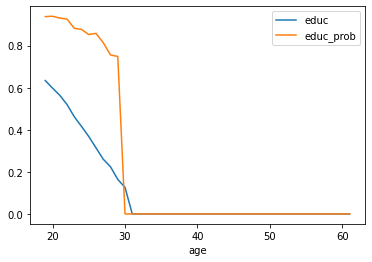

In [501]:
pd.DataFrame(educ_list).groupby('age').mean()[['educ', 'educ_prob']].plot()


In [502]:
env.reset()
sqrt_Ys = list()
Us = list()
N_EPISODES = 3000
actions, action = ACTIONS, -1
beta_L = 0.1
res = list()

for i in range(N_EPISODES):

      
    beta_L = np.random.uniform(0.1, 40)
    env.reset(parameters={'beta_L': beta_L})
    Us_ = list()
    done = False
    scaled_rewards = list()

    while not done:
        action = np.random.randint(0,4)
        states, utility, done, info = env.step(actions[action])
        sqrt_Y = np.sqrt(info['Y'])
        scaled_reward = reward_scaler_model2(utility, beta_L)
        sqrt_Ys.append(sqrt_Y)
        Us.append(utility)
        Us_.append(utility)
        scaled_rewards.append(scaled_reward)
        
    res.append({'beta_L': beta_L, 'U': np.mean(Us_), 'U_min':min(Us_), 'U_max': max(Us_), 'scaled': np.mean(scaled_rewards)})
    

In [503]:
np.mean(sqrt_Ys), np.std(sqrt_Ys)

(111.98165525048962, 16.99165934814817)

In [504]:
np.mean(Us), np.std(Us)

(353.3627037606275, 139.12688438074832)

In [505]:
df_res = pd.DataFrame(res)
np.std(df_res['scaled']), np.mean(df_res['scaled'])

(0.894217859095897, -1.1728846559190584)

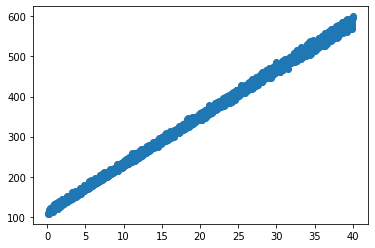

In [506]:
plt.scatter(df_res['beta_L'], df_res['U'])

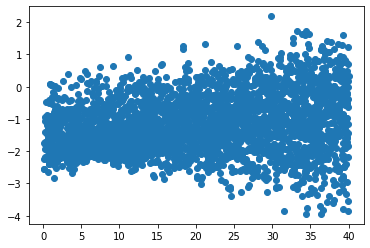

In [509]:
plt.scatter(df_res['beta_L'], df_res['scaled'])

In [510]:
from scipy.stats import linregress

In [511]:
linregress(df_res['beta_L'], df_res['U']).slope

11.899071131685071

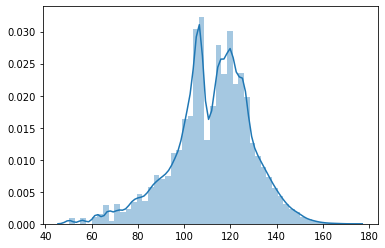

In [512]:


sbn.distplot(sqrt_Ys)

In [513]:
from agents.new_doubledqnagent import DDQNAgent as Agent

In [514]:
def draw_beta_L(beta_L_min=0.1, beta_L_max=12.0):
    return np.random.uniform(beta_L_min, beta_L_max)

def transform_action(dqn_action):
    return np.array(ACTIONS)[dqn_action]

def create_return_array(state, _action, scaled_reward, episode):
    return np.append(state, [_action, scaled_reward, episode])

In [515]:
env = EnvironmentModel2(**parameters)
lr = 0.0005
agent = Agent(gamma=0.99, epsilon=1.0, alpha=lr, input_dims=15,
              n_actions=4, mem_size=1000000, batch_size=64, epsilon_dec=0.9999,
              epsilon_end=0.01, state_scaler_mu = STATES_MU2,
              state_scaler_sigma = STATES_SIGMA2)

In [516]:
N_EPISODES = 2000

Episode: 0 epsilon: 1.0 total score (last 10): nan


/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


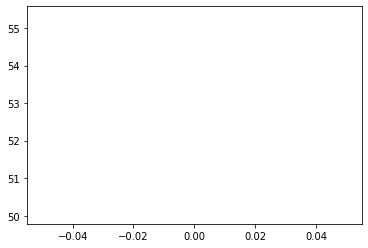

Episode: 10 epsilon: 0.9640599185586783 total score (last 10): -49.638901878150385
Episode: 20 epsilon: 0.9234819910736651 total score (last 10): -24.264801727249274
Episode: 30 epsilon: 0.8846120157265657 total score (last 10): 28.111057982798023
Episode: 40 epsilon: 0.847378103668288 total score (last 10): -20.59848561275826
Episode: 50 epsilon: 0.811711391899535 total score (last 10): 9.675570203953999


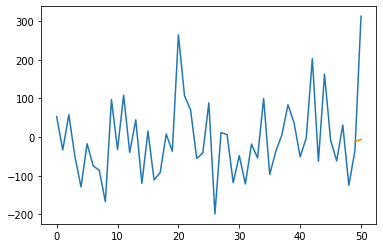

Episode: 60 epsilon: 0.7775459159107581 total score (last 10): -1.405416235229178
Episode: 70 epsilon: 0.7448184876827848 total score (last 10): -3.796673128828645
Episode: 80 epsilon: 0.713468578822478 total score (last 10): 0.3274117947464609
Episode: 90 epsilon: 0.6834382086172971 total score (last 10): -1.7395975671783677
Episode: 100 epsilon: 0.6546718368017131 total score (last 10): 14.34495491277666


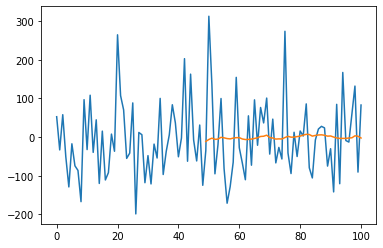

Episode: 110 epsilon: 0.6271162608371637 total score (last 10): -2.6631117294568347
Episode: 120 epsilon: 0.600720517515557 total score (last 10): 6.605376796691205
Episode: 130 epsilon: 0.5754357887043543 total score (last 10): 46.5001983961446
Episode: 140 epsilon: 0.5512153110589036 total score (last 10): 8.203795840853449
Episode: 150 epsilon: 0.5280142895350369 total score (last 10): 40.24747917525005


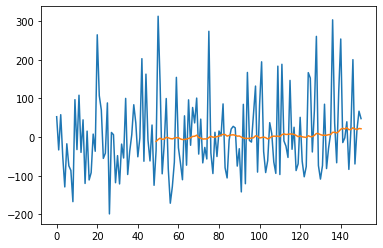

Episode: 160 epsilon: 0.5057898145419926 total score (last 10): 106.75931320669366
Episode: 170 epsilon: 0.484500782582415 total score (last 10): 0.4992577790109396
Episode: 180 epsilon: 0.46410782023267466 total score (last 10): 41.665516247311764
Episode: 190 epsilon: 0.4445732113229038 total score (last 10): 69.70750539965681
Episode: 200 epsilon: 0.4258608271820816 total score (last 10): 99.32034534447217


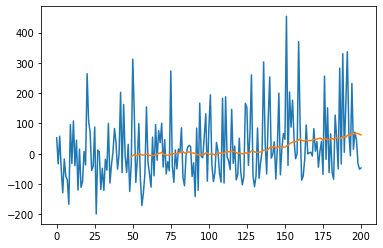

Episode: 210 epsilon: 0.4079360598191387 total score (last 10): 98.74936301637221
Episode: 220 epsilon: 0.3907657579165237 total score (last 10): 83.41461441798299
Episode: 230 epsilon: 0.3743181655178378 total score (last 10): 102.46724079260511
Episode: 240 epsilon: 0.3585628632961515 total score (last 10): 73.16668396815191
Episode: 250 epsilon: 0.3434707122943729 total score (last 10): 128.4080863140112


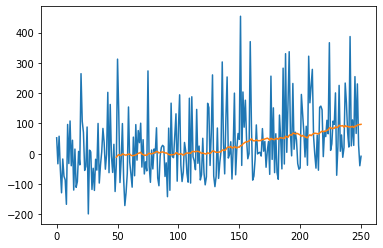

Episode: 260 epsilon: 0.3290138000336249 total score (last 10): 39.46616351906999
Episode: 270 epsilon: 0.3151653888899552 total score (last 10): -10.099701056977713
Episode: 280 epsilon: 0.3018998666439078 total score (last 10): 69.23811194491809
Episode: 290 epsilon: 0.2891926991114924 total score (last 10): 147.72623877489445
Episode: 300 epsilon: 0.2770203847689501 total score (last 10): 136.26144921790024


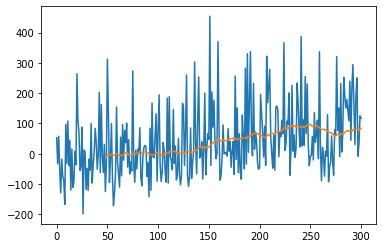

Episode: 310 epsilon: 0.2653604112873939 total score (last 10): 51.03469045139403
Episode: 320 epsilon: 0.2541912138969337 total score (last 10): 89.85467016123636
Episode: 330 epsilon: 0.24349213550328125 total score (last 10): 128.7663208325384
Episode: 340 epsilon: 0.23324338848308065 total score (last 10): 78.64650549145013
Episode: 350 epsilon: 0.22342601808729118 total score (last 10): 187.685302603905


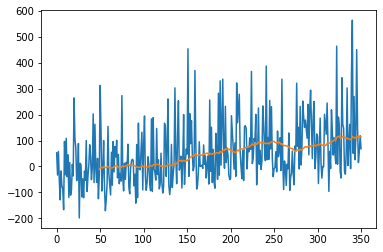

Episode: 360 epsilon: 0.21402186738495152 total score (last 10): 81.88032354815303
Episode: 370 epsilon: 0.20501354368248126 total score (last 10): 126.81907032885296
Episode: 380 epsilon: 0.19638438635641947 total score (last 10): 185.48631717628444
Episode: 390 epsilon: 0.18811843604010126 total score (last 10): 100.46663898522468
Episode: 400 epsilon: 0.180200405107292 total score (last 10): 148.5300884299741


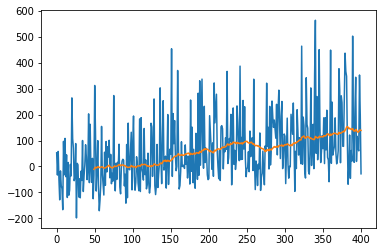

Episode: 410 epsilon: 0.17261564939817997 total score (last 10): 86.1847767505434
Episode: 420 epsilon: 0.16535014113544708 total score (last 10): 155.77576977781166
Episode: 430 epsilon: 0.1583904429803137 total score (last 10): 50.03976979001888
Episode: 440 epsilon: 0.15172368318058757 total score (last 10): 68.43165179726395
Episode: 450 epsilon: 0.14533753176474418 total score (last 10): 144.4142121766921


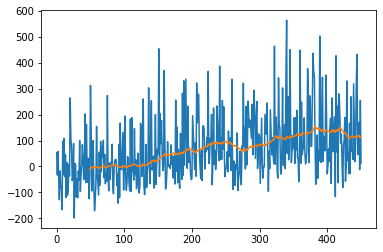

Episode: 460 epsilon: 0.13922017773801795 total score (last 10): 145.8463827942647
Episode: 470 epsilon: 0.13336030723831901 total score (last 10): 133.41181032621571
Episode: 480 epsilon: 0.12774708261159037 total score (last 10): 201.15272991173853
Episode: 490 epsilon: 0.12237012236789019 total score (last 10): 144.81348475554427
Episode: 500 epsilon: 0.11721948198113886 total score (last 10): 294.0719584921952


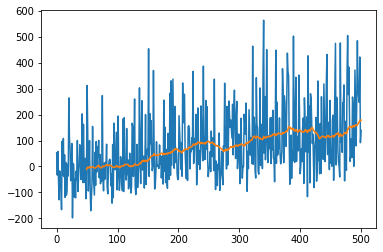

Episode: 510 epsilon: 0.11228563549701923 total score (last 10): 156.24794238230203
Episode: 520 epsilon: 0.107559457915009 total score (last 10): 150.7884645824066
Episode: 530 epsilon: 0.10303220831196792 total score (last 10): 108.81353637191313
Episode: 540 epsilon: 0.09869551367606369 total score (last 10): 165.3447923003983
Episode: 550 epsilon: 0.09454135342113795 total score (last 10): 214.06694790561943


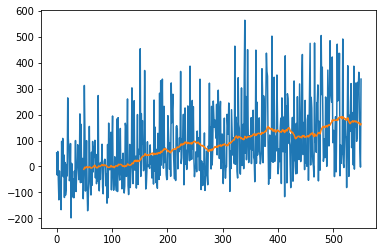

Episode: 560 epsilon: 0.09056204455287445 total score (last 10): 217.0668877585458
Episode: 570 epsilon: 0.08675022745933204 total score (last 10): 143.03809036505996
Episode: 580 epsilon: 0.08309885229956374 total score (last 10): 158.69734215444777
Episode: 590 epsilon: 0.07960116596514924 total score (last 10): 160.31565050309598
Episode: 600 epsilon: 0.07625069959052229 total score (last 10): 107.93022910107058


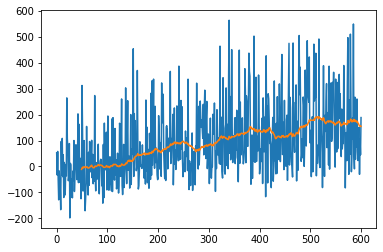

Episode: 610 epsilon: 0.07304125658900062 total score (last 10): 89.97887159631509
Episode: 620 epsilon: 0.06996690119238395 total score (last 10): 173.86584148606454
Episode: 630 epsilon: 0.06702194747293001 total score (last 10): 112.21057034865329
Episode: 640 epsilon: 0.06420094882740288 total score (last 10): 129.42858373168377
Episode: 650 epsilon: 0.0614986879037436 total score (last 10): 109.1302842139227


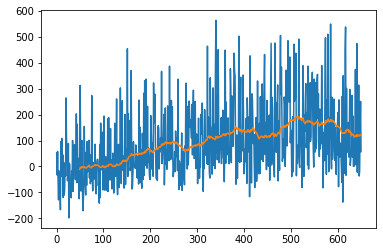

Episode: 660 epsilon: 0.05891016695173428 total score (last 10): 139.11792332376754
Episode: 670 epsilon: 0.05643059857981053 total score (last 10): 200.51527634691448
Episode: 680 epsilon: 0.05405539690092427 total score (last 10): 265.6237466786375
Episode: 690 epsilon: 0.051780169051084124 total score (last 10): 164.55745416355361
Episode: 700 epsilon: 0.049600707064885216 total score (last 10): 121.79109582408786


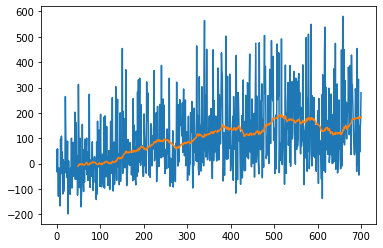

Episode: 710 epsilon: 0.04751298009300428 total score (last 10): 254.83427083661854
Episode: 720 epsilon: 0.045513126947264976 total score (last 10): 166.25711859102518
Episode: 730 epsilon: 0.043597448959486536 total score (last 10): 157.58112897300398
Episode: 740 epsilon: 0.04176240314090865 total score (last 10): 207.16441009368245
Episode: 750 epsilon: 0.0400045956295402 total score (last 10): 207.28995983183464


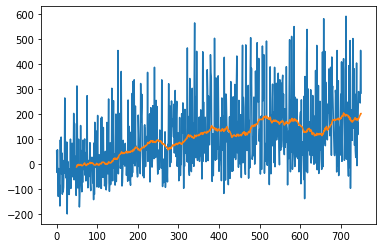

Episode: 760 epsilon: 0.03832077541331378 total score (last 10): 142.922440013884
Episode: 770 epsilon: 0.036707828317436506 total score (last 10): 133.90013731562453
Episode: 780 epsilon: 0.035162771244817856 total score (last 10): 169.60214416367836
Episode: 790 epsilon: 0.033682746658921174 total score (last 10): 189.28628819529922
Episode: 800 epsilon: 0.032265017298836234 total score (last 10): 213.45564373963305


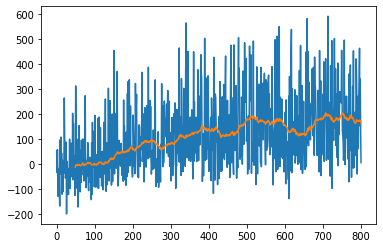

Episode: 810 epsilon: 0.030906961116796926 total score (last 10): 123.89046331243864
Episode: 820 epsilon: 0.02960606642878365 total score (last 10): 220.4037633616874
Episode: 830 epsilon: 0.028359927269238718 total score (last 10): 190.31265257942198
Episode: 840 epsilon: 0.027166238941305806 total score (last 10): 97.18261509076416
Episode: 850 epsilon: 0.026022793754362495 total score (last 10): 199.80537316748612


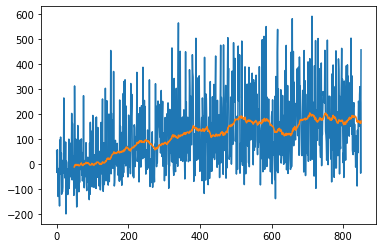

Episode: 860 epsilon: 0.024927476940962916 total score (last 10): 236.94479619552698
Episode: 870 epsilon: 0.02387826274563886 total score (last 10): 283.2737294902508
Episode: 880 epsilon: 0.02287321067832622 total score (last 10): 197.80930475049522
Episode: 890 epsilon: 0.021910461925487082 total score (last 10): 183.2869397199748
Episode: 900 epsilon: 0.020988235912289925 total score (last 10): 150.8652924136962


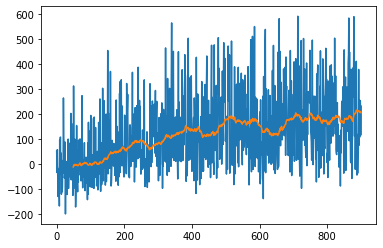

Episode: 910 epsilon: 0.020104827009490085 total score (last 10): 193.2070775351872
Episode: 920 epsilon: 0.019258601378919812 total score (last 10): 103.67433943806401
Episode: 930 epsilon: 0.018447993951753932 total score (last 10): 210.8340677850691
Episode: 940 epsilon: 0.017671505533962 total score (last 10): 117.37880960475516
Episode: 950 epsilon: 0.016927700033594142 total score (last 10): 181.69792192492397


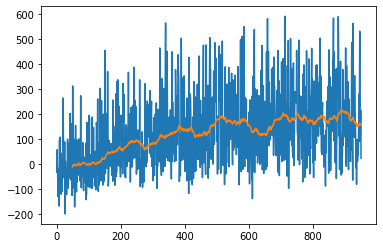

Episode: 960 epsilon: 0.01621520180477221 total score (last 10): 32.88118409690487
Episode: 970 epsilon: 0.015532693103474243 total score (last 10): 164.39006072805427
Episode: 980 epsilon: 0.01487891165040641 total score (last 10): 132.30253465527986
Episode: 990 epsilon: 0.014252648296455585 total score (last 10): 228.9504432623063
Episode: 1000 epsilon: 0.013652744786404457 total score (last 10): 167.73446940225466


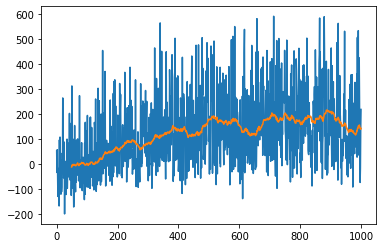

Episode: 1010 epsilon: 0.013078091616773296 total score (last 10): 119.37323012243188
Episode: 1020 epsilon: 0.012527625983826755 total score (last 10): 276.56392294958414
Episode: 1030 epsilon: 0.012000329817950373 total score (last 10): 131.68283410651648
Episode: 1040 epsilon: 0.011495227900761405 total score (last 10): 71.02020365463069
Episode: 1050 epsilon: 0.011011386061471829 total score (last 10): 152.4809607472362


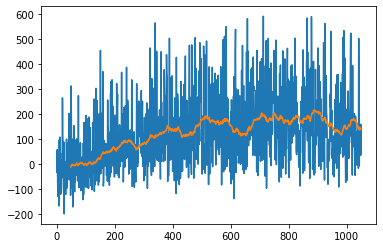

Episode: 1060 epsilon: 0.010547909449167578 total score (last 10): 138.67499851735582
Episode: 1070 epsilon: 0.01010394087780874 total score (last 10): 273.46850665527177
Episode: 1080 epsilon: 0.01 total score (last 10): 101.05436382653308
Episode: 1090 epsilon: 0.01 total score (last 10): 126.06742514164641
Episode: 1100 epsilon: 0.01 total score (last 10): 246.07273349628284


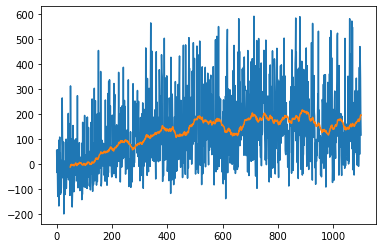

Episode: 1110 epsilon: 0.01 total score (last 10): 192.97441178214535
Episode: 1120 epsilon: 0.01 total score (last 10): 87.66281473693874
Episode: 1130 epsilon: 0.01 total score (last 10): 208.96893754544757
Episode: 1140 epsilon: 0.01 total score (last 10): 250.34741220768035
Episode: 1150 epsilon: 0.01 total score (last 10): 141.78278013346102


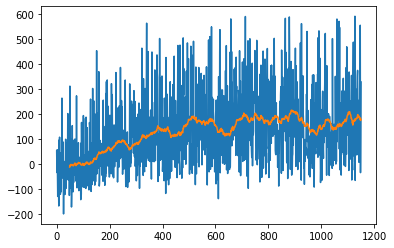

Episode: 1160 epsilon: 0.01 total score (last 10): 114.68674786908312
Episode: 1170 epsilon: 0.01 total score (last 10): 174.84996423348392
Episode: 1180 epsilon: 0.01 total score (last 10): 277.3668673451176
Episode: 1190 epsilon: 0.01 total score (last 10): 254.54403441330467
Episode: 1200 epsilon: 0.01 total score (last 10): 225.11137427308864


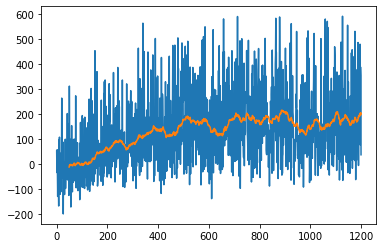

Episode: 1210 epsilon: 0.01 total score (last 10): 177.23955153310425
Episode: 1220 epsilon: 0.01 total score (last 10): 164.92594408387794
Episode: 1230 epsilon: 0.01 total score (last 10): 212.7227133350154
Episode: 1240 epsilon: 0.01 total score (last 10): 246.8749430904339
Episode: 1250 epsilon: 0.01 total score (last 10): 53.06735413856067


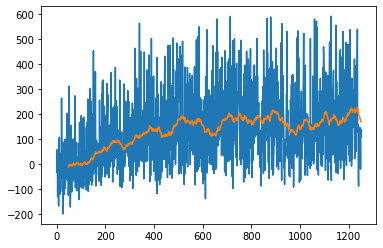

Episode: 1260 epsilon: 0.01 total score (last 10): 95.34935143581518
Episode: 1270 epsilon: 0.01 total score (last 10): 162.82334156695515
Episode: 1280 epsilon: 0.01 total score (last 10): 190.14528496448463
Episode: 1290 epsilon: 0.01 total score (last 10): 138.6491215236565
Episode: 1300 epsilon: 0.01 total score (last 10): 168.24826571395164


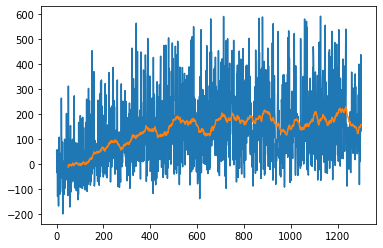

Episode: 1310 epsilon: 0.01 total score (last 10): 152.49963849196365
Episode: 1320 epsilon: 0.01 total score (last 10): 215.23867816738976
Episode: 1330 epsilon: 0.01 total score (last 10): 160.70374873877824
Episode: 1340 epsilon: 0.01 total score (last 10): 280.662523362252
Episode: 1350 epsilon: 0.01 total score (last 10): 185.94107454614561


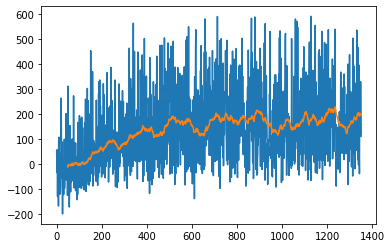

Episode: 1360 epsilon: 0.01 total score (last 10): 193.83977813949966
Episode: 1370 epsilon: 0.01 total score (last 10): 129.86091479478472
Episode: 1380 epsilon: 0.01 total score (last 10): 110.99796578635824
Episode: 1390 epsilon: 0.01 total score (last 10): 189.52613994345276
Episode: 1400 epsilon: 0.01 total score (last 10): 169.48056795427462


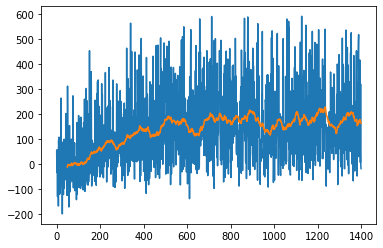

Episode: 1410 epsilon: 0.01 total score (last 10): 250.2617372592628
Episode: 1420 epsilon: 0.01 total score (last 10): 64.6148444906608
Episode: 1430 epsilon: 0.01 total score (last 10): 101.32233587240762
Episode: 1440 epsilon: 0.01 total score (last 10): 194.58278239976892
Episode: 1450 epsilon: 0.01 total score (last 10): 101.71675434086887


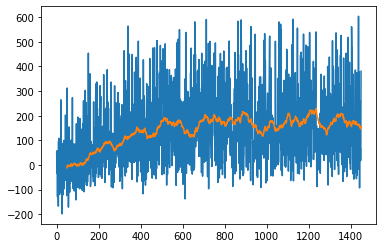

Episode: 1460 epsilon: 0.01 total score (last 10): 232.2514898874331
Episode: 1470 epsilon: 0.01 total score (last 10): 160.98524255570166
Episode: 1480 epsilon: 0.01 total score (last 10): 295.59251706281117
Episode: 1490 epsilon: 0.01 total score (last 10): 151.63667462493305
Episode: 1500 epsilon: 0.01 total score (last 10): 213.57714194738844


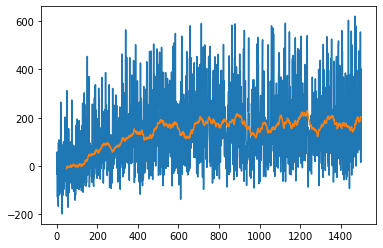

Episode: 1510 epsilon: 0.01 total score (last 10): 115.7837898317344
Episode: 1520 epsilon: 0.01 total score (last 10): 112.63890275031761
Episode: 1530 epsilon: 0.01 total score (last 10): 159.59581443871815
Episode: 1540 epsilon: 0.01 total score (last 10): 235.82527334661603
Episode: 1550 epsilon: 0.01 total score (last 10): 161.08434088392193


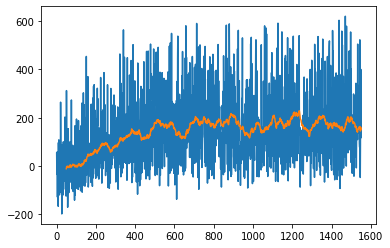

Episode: 1560 epsilon: 0.01 total score (last 10): 125.96011900154771
Episode: 1570 epsilon: 0.01 total score (last 10): 174.74526403766384
Episode: 1580 epsilon: 0.01 total score (last 10): 140.66590876757493
Episode: 1590 epsilon: 0.01 total score (last 10): 118.71488766837105
Episode: 1600 epsilon: 0.01 total score (last 10): 211.04777767573913


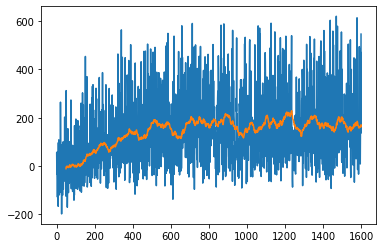

Episode: 1610 epsilon: 0.01 total score (last 10): 109.01123576995093
Episode: 1620 epsilon: 0.01 total score (last 10): 120.59508647968083
Episode: 1630 epsilon: 0.01 total score (last 10): 101.01145391840852
Episode: 1640 epsilon: 0.01 total score (last 10): 192.4444365620526
Episode: 1650 epsilon: 0.01 total score (last 10): 141.29734501912083


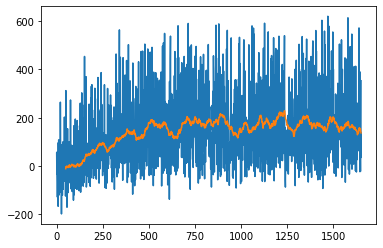

Episode: 1660 epsilon: 0.01 total score (last 10): 213.98335883952694
Episode: 1670 epsilon: 0.01 total score (last 10): 91.31439811155943
Episode: 1680 epsilon: 0.01 total score (last 10): 205.39071922543295
Episode: 1690 epsilon: 0.01 total score (last 10): 75.88157873693254
Episode: 1700 epsilon: 0.01 total score (last 10): 170.98853228739338


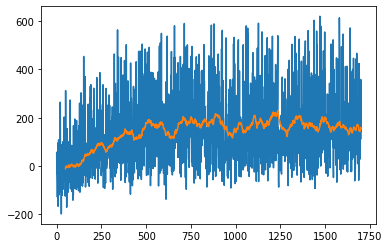

Episode: 1710 epsilon: 0.01 total score (last 10): 133.98237030113907
Episode: 1720 epsilon: 0.01 total score (last 10): 166.1132475321591
Episode: 1730 epsilon: 0.01 total score (last 10): 97.14843015712077
Episode: 1740 epsilon: 0.01 total score (last 10): 193.17454988639818
Episode: 1750 epsilon: 0.01 total score (last 10): 141.63254484271357


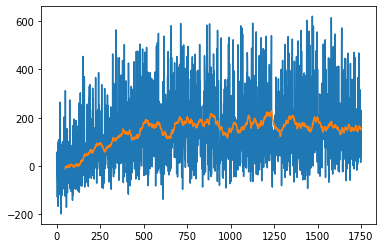

Episode: 1760 epsilon: 0.01 total score (last 10): 105.6895116436068
Episode: 1770 epsilon: 0.01 total score (last 10): 162.48792192171757
Episode: 1780 epsilon: 0.01 total score (last 10): 132.9785022695782
Episode: 1790 epsilon: 0.01 total score (last 10): 205.1830901077367
Episode: 1800 epsilon: 0.01 total score (last 10): 191.30015618948792


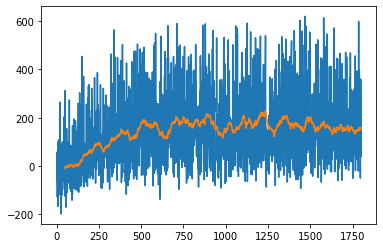

Episode: 1810 epsilon: 0.01 total score (last 10): 166.5052713748429
Episode: 1820 epsilon: 0.01 total score (last 10): 163.4075016824409
Episode: 1830 epsilon: 0.01 total score (last 10): 139.451113386991
Episode: 1840 epsilon: 0.01 total score (last 10): 137.75890221142416
Episode: 1850 epsilon: 0.01 total score (last 10): 188.05434641848294


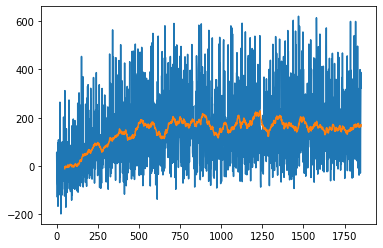

Episode: 1860 epsilon: 0.01 total score (last 10): 234.0619027333529
Episode: 1870 epsilon: 0.01 total score (last 10): 206.7525934138805
Episode: 1880 epsilon: 0.01 total score (last 10): 123.88804524599692
Episode: 1890 epsilon: 0.01 total score (last 10): 185.9795735540569
Episode: 1900 epsilon: 0.01 total score (last 10): 93.65546084112641


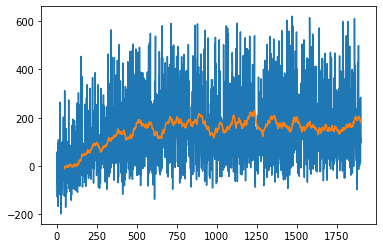

Episode: 1910 epsilon: 0.01 total score (last 10): 187.6868131645498
Episode: 1920 epsilon: 0.01 total score (last 10): 187.2846646656968
Episode: 1930 epsilon: 0.01 total score (last 10): 180.51798372599177
Episode: 1940 epsilon: 0.01 total score (last 10): 232.63056213251215
Episode: 1950 epsilon: 0.01 total score (last 10): 125.38411759453781


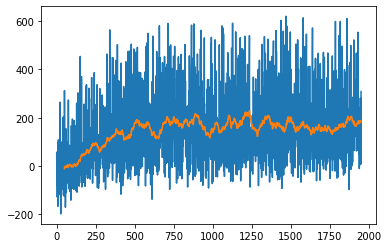

Episode: 1960 epsilon: 0.01 total score (last 10): 187.10772097379606
Episode: 1970 epsilon: 0.01 total score (last 10): 98.159859886738
Episode: 1980 epsilon: 0.01 total score (last 10): 139.1280029195618
Episode: 1990 epsilon: 0.01 total score (last 10): 164.49694567799435


In [517]:
results = list()
total_score = list()

for episode in range(N_EPISODES):
    if episode % 10 == 0:
        print('Episode:', episode, 'epsilon:', agent.epsilon, 'total score (last 10):', np.mean(total_score[-10:-1]))
    beta_L = draw_beta_L(beta_L_max=100.0)
    
    state = env.reset(parameters={'beta_L': beta_L})
    
    done, G = False, 0
    while done is False:
        
        action = agent.choose_action(state)
        _action = transform_action(action)
        new_state, reward, done, info = env.step(_action)
        scaled_reward = reward_scaler_model2(reward, beta_L)
        
        agent.remember(state, action, scaled_reward, new_state, int(done))
        state = new_state
        agent.learn()
        
        G += scaled_reward
        results.append(create_return_array(state, _action, scaled_reward, episode))
    
    total_score.append(G)
    
    if episode % 50 == 0:
        plt.plot(total_score)
        plt.plot(pd.Series(total_score).rolling(50).mean())
        plt.show()

In [518]:
np.array([1,2, np.array([2,3])])

array([1, 2, array([2, 3])], dtype=object)

In [519]:
agent.epsilon=0

# Estimation

In [520]:
size_multiplier = 0.7
FIGSIZE = (14*size_multiplier, 8*size_multiplier)

In [521]:
with open('..//data//women_hours_empirical', 'rb') as f:
    women_hours = pickle.load(f)

In [522]:
parameters

{'beta_L': 1,
 'sigma_epsilon': 15.11,
 'S_min': 120.0,
 'alpha': 4.609,
 'eta_G': 0.164,
 'eta_G_sq': 0.015,
 'delta': 0.209,
 'zeta': 0.5}

In [523]:
Environment = EnvironmentModel2

In [524]:
from environments import translate_action_model1 as translate_action

In [525]:
def simulate_observations(parameters, n_episodes):

    env = Environment(**parameters)

    rewards_history, action_history, states_history = list(), list(), list()
    agent.epsilon=0.0


    for e in range(n_episodes):
        env.reset()
        state = env.states
        for time in range(18, 500):
            action = agent.choose_action(state)
            _action = translate_action(action)
            next_state, reward, done, _ = env.step(_action)
            scaled_reward = (reward - 24 ) / 5

            rewards_history.append([reward, e, time])
            action_history.append([_action, e, time])
            states_history.append(np.append(state, [e, time, _action]))
            
            state = next_state
            if done:
                #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
                break

    df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
    df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])
    
    states_cols = ['Q', 'G', 'K', 'Z', 'beta_L', 'E_prob', 'E', \
                   'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4',\
                   'episode', 'time', 'action']
    df_DQAgent_states = pd.DataFrame(states_history, columns=states_cols)
    
    
    return df_DQAgent, df_DQAgent_action, df_DQAgent_states


def get_simulated_mean(df_action):
    sim_avg_actions = df_action.drop('episode',axis=1).loc[df_action['actions'] > 0].groupby('Q').mean()

    sim_vals = np.zeros(shape=90)
    sim_avg_actions
    for ix in range(len(sim_vals)):
        obs = sim_avg_actions.loc[sim_avg_actions.index == ix]
        if len(obs) == 1:

            sim_vals[ix] = float(obs['actions'])

    return sim_vals

def trim_obs(array):
    return array[18:61]

def calc_loss(true_vals, sim_vals):
    return np.mean((true_vals - sim_vals)**2)

def calc_loss_frac_labour(df_action):
    N_SIMS = 300
    val = df_action.loc[df_action['actions'] == 0].groupby('Q')['actions'].count() / N_SIMS
    if len(val) == 0:
        val = 1
    return ((np.mean(val) - 0.15) * 45)**2 #times 45 for scaling
    
def objective(x):
    print('\n new iteration')

    np.random.seed(10)
    
    n_episodes = 300
    
    beta_L = x
    parameters = {
        'beta_L' : x,
        'sigma_epsilon' : 0.1, 
        'S_min': 120.0,
        'alpha': 4.609,
        'eta_G': 0.164,
        'eta_G_sq' : 0.015,
        'delta': 0.209,
        'sigma_epsilon': 15.11,
        'zeta': 0.5
    }
    
    df, df_action, df_states = simulate_observations(parameters, n_episodes)
    sim_vals = get_simulated_mean(df_action)
    true_vals, sim_vals = trim_obs(women_hours), trim_obs(sim_vals)
    mse_hours = calc_loss(true_vals, sim_vals)
    mse_fraction = calc_loss_frac_labour(df_action)
    mse = mse_hours + mse_fraction
    print(f'beta L: {beta_L:.1f}, mse_hours: {mse_hours:.1f}, mse_fraction: {mse_fraction:.1f}, mse, {mse:.1f}')
    
    return mse 

In [526]:
beta_Ls, mses = np.linspace(0.0, 60.0), list()

for beta_L in beta_Ls:
    mse = objective(beta_L)
    mses.append(mse)


 new iteration
beta L: 0.0, mse_hours: 205.7, mse_fraction: 42.0, mse, 247.7

 new iteration
beta L: 1.2, mse_hours: 209.3, mse_fraction: 42.6, mse, 251.9

 new iteration
beta L: 2.4, mse_hours: 211.9, mse_fraction: 43.6, mse, 255.5

 new iteration
beta L: 3.7, mse_hours: 214.1, mse_fraction: 43.6, mse, 257.7

 new iteration
beta L: 4.9, mse_hours: 216.1, mse_fraction: 1463.1, mse, 1679.2

 new iteration
beta L: 6.1, mse_hours: 217.6, mse_fraction: 1463.1, mse, 1680.6

 new iteration
beta L: 7.3, mse_hours: 218.8, mse_fraction: 43.6, mse, 262.4

 new iteration
beta L: 8.6, mse_hours: 219.4, mse_fraction: 43.6, mse, 262.9

 new iteration
beta L: 9.8, mse_hours: 219.4, mse_fraction: 43.3, mse, 262.7

 new iteration
beta L: 11.0, mse_hours: 219.7, mse_fraction: 42.5, mse, 262.2

 new iteration
beta L: 12.2, mse_hours: 219.2, mse_fraction: 42.3, mse, 261.5

 new iteration
beta L: 13.5, mse_hours: 218.4, mse_fraction: 40.6, mse, 259.0

 new iteration
beta L: 14.7, mse_hours: 217.7, mse_fra

In [527]:
agent.choose_action(state)

0

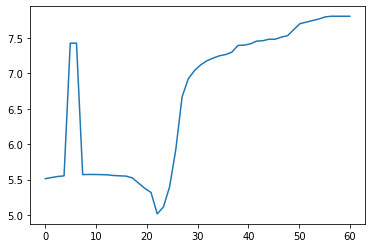

In [528]:
plt.plot(beta_Ls, np.log(mses))

In [529]:
#beta_Ls_2, mses_2 = np.linspace(10.0, 40.0), list()

#for beta_L in beta_Ls_2:
#    mse = objective(beta_L)
#    mses_2.append(mse)

In [562]:
#plt.plot(beta_Ls_2, np.log(mses_2))

In [570]:
# ENDOGENT FIND MIN BETA_L

beta_L_ix = np.argmin(np.log(mses))
beta_L = beta_Ls[beta_L_ix]
print('beta_L:', beta_L, 'beta_L_ix:' ,beta_L_ix)

beta_L: 22.040816326530614 beta_L_ix: 18


In [571]:
# beta_L: 25.7 (virker godt)
#beta_L = 25.7

In [572]:
parameters = {
    'beta_L' : beta_L,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'zeta': 0.5
}

env = EnvironmentModel2(**parameters)

In [573]:
N_EPISODES = 10000

results = list()
infos = list()
total_score = list()

tic = time.time()
for episode in range(N_EPISODES):

    if episode % 50 == 0:
        print('Episode:', episode, 'epsilon:', agent.epsilon, f'total score (last 10): {np.mean(total_score[-10:-1]):.1f}')
        
        toc = time.time()
        time_for_50 = toc - tic
        remaining_episodes = 5000 - episode
        
        print(f'time for 50 episodes:{time_for_50:.1f} seconds. Remaining {( remaining_episodes / 50 ) * time_for_50 / 60:.1f} minutes')
        tic = time.time()
        
    state = env.reset()
    
    done, G = False, 0
    while done is False:
        
        action = agent.choose_action(state)
        _action = transform_action(action)
        new_state, reward, done, info = env.step(_action)
        scaled_reward = reward_scaler_model2(reward, beta_L)
        
        state = new_state
        
        G += scaled_reward
        results.append(create_return_array(state, _action, scaled_reward, episode))
        infos.append(info)
        
    total_score.append(G)
    

/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 0 epsilon: 0.0 total score (last 10): nan
time for 50 episodes:0.0 seconds. Remaining 0.0 minutes
Episode: 50 epsilon: 0.0 total score (last 10): 6.0
time for 50 episodes:2.8 seconds. Remaining 4.5 minutes
Episode: 100 epsilon: 0.0 total score (last 10): 0.1
time for 50 episodes:2.2 seconds. Remaining 3.6 minutes
Episode: 150 epsilon: 0.0 total score (last 10): 37.5
time for 50 episodes:1.9 seconds. Remaining 3.1 minutes
Episode: 200 epsilon: 0.0 total score (last 10): 22.5
time for 50 episodes:1.8 seconds. Remaining 2.8 minutes
Episode: 250 epsilon: 0.0 total score (last 10): -3.2
time for 50 episodes:1.9 seconds. Remaining 3.0 minutes
Episode: 300 epsilon: 0.0 total score (last 10): 12.0
time for 50 episodes:1.7 seconds. Remaining 2.7 minutes
Episode: 350 epsilon: 0.0 total score (last 10): 13.7
time for 50 episodes:1.8 seconds. Remaining 2.8 minutes
Episode: 400 epsilon: 0.0 total score (last 10): 32.8
time for 50 episodes:1.7 seconds. Remaining 2.6 minutes
Episode: 450 eps

Episode: 3750 epsilon: 0.0 total score (last 10): 17.3
time for 50 episodes:2.7 seconds. Remaining 1.1 minutes
Episode: 3800 epsilon: 0.0 total score (last 10): 16.5
time for 50 episodes:2.9 seconds. Remaining 1.2 minutes
Episode: 3850 epsilon: 0.0 total score (last 10): 20.7
time for 50 episodes:1.8 seconds. Remaining 0.7 minutes
Episode: 3900 epsilon: 0.0 total score (last 10): -4.5
time for 50 episodes:1.8 seconds. Remaining 0.6 minutes
Episode: 3950 epsilon: 0.0 total score (last 10): 14.9
time for 50 episodes:1.9 seconds. Remaining 0.7 minutes
Episode: 4000 epsilon: 0.0 total score (last 10): 24.4
time for 50 episodes:1.7 seconds. Remaining 0.6 minutes
Episode: 4050 epsilon: 0.0 total score (last 10): 4.1
time for 50 episodes:3.9 seconds. Remaining 1.2 minutes
Episode: 4100 epsilon: 0.0 total score (last 10): 66.2
time for 50 episodes:2.4 seconds. Remaining 0.7 minutes
Episode: 4150 epsilon: 0.0 total score (last 10): 31.3
time for 50 episodes:2.1 seconds. Remaining 0.6 minutes
Ep

Episode: 7450 epsilon: 0.0 total score (last 10): -18.0
time for 50 episodes:1.7 seconds. Remaining -1.4 minutes
Episode: 7500 epsilon: 0.0 total score (last 10): 48.0
time for 50 episodes:1.9 seconds. Remaining -1.6 minutes
Episode: 7550 epsilon: 0.0 total score (last 10): 8.2
time for 50 episodes:1.7 seconds. Remaining -1.4 minutes
Episode: 7600 epsilon: 0.0 total score (last 10): 60.3
time for 50 episodes:1.8 seconds. Remaining -1.6 minutes
Episode: 7650 epsilon: 0.0 total score (last 10): 30.6
time for 50 episodes:1.8 seconds. Remaining -1.6 minutes
Episode: 7700 epsilon: 0.0 total score (last 10): 27.7
time for 50 episodes:1.7 seconds. Remaining -1.5 minutes
Episode: 7750 epsilon: 0.0 total score (last 10): 25.4
time for 50 episodes:1.8 seconds. Remaining -1.6 minutes
Episode: 7800 epsilon: 0.0 total score (last 10): 20.9
time for 50 episodes:1.6 seconds. Remaining -1.5 minutes
Episode: 7850 epsilon: 0.0 total score (last 10): 28.4
time for 50 episodes:1.8 seconds. Remaining -1.7 

In [574]:
states_cols = ['Q', 'G', 'K', 'Z', 'beta_L', 'E_prob', 'E', \
               'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4',\
               'action', 'scaled_reward', 'episode']

In [575]:
df_results = pd.DataFrame(results, columns=states_cols)

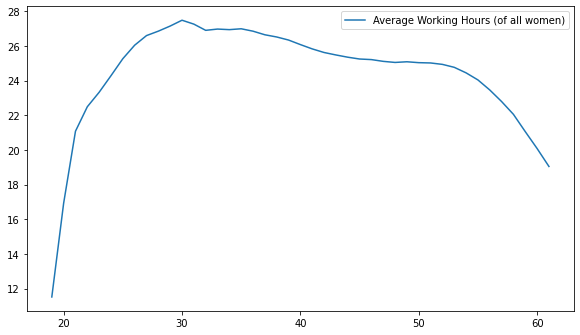

In [613]:
f, ax = plt.subplots(1,1,figsize=FIGSIZE)
plt.plot(df_results.groupby('Q')['action'].mean(), label = 'Average Working Hours (of all women)')
ax.legend()

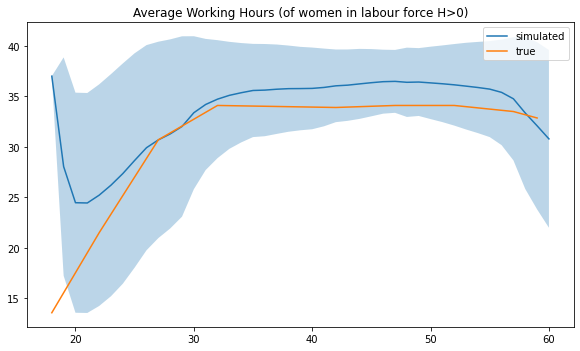

In [612]:
with open("..//data//women_hours_empirical", "rb") as f:
    women_hours_data = pickle.load(f)

f, ax = plt.subplots(1,1, figsize=FIGSIZE)
_x = range(18,60)
_xx = range(18, 61)
_mean = df_results.loc[df_results['action'] > 0].groupby('Q')['action'].mean()
_std = df_results.loc[df_results['action'] > 0].groupby('Q')['action'].std()
ax.plot(_xx, _mean, label='simulated')
ax.fill_between(_xx, _mean -_std, _mean + _std, alpha=0.3)
ax.plot(_x,women_hours_data[18:60], label = 'true')
ax.set_title("Average Working Hours (of women in labour force H>0)")
ax.legend()

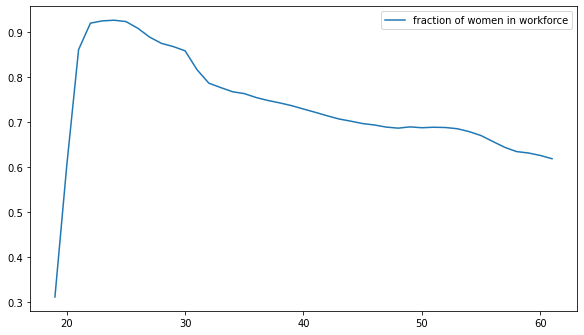

In [614]:

f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.plot(df_results.loc[df_results['action'] > 0].groupby('Q')['action'].count() / max(df_results['episode']) ,label='fraction of women in workforce')
ax.legend()


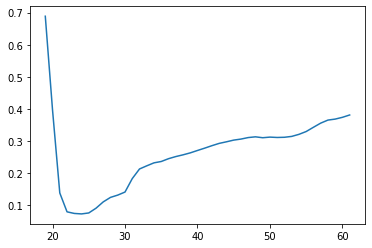

In [579]:
plt.plot(df_results.loc[df_results['action'] < 1].groupby('Q')['action'].count() / 10000)

(array([112966.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  47922.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,  13550.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 255562.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
        43.5, 44.5, 45.5, 46.5]),
 <a list of 47 Patch objects>)

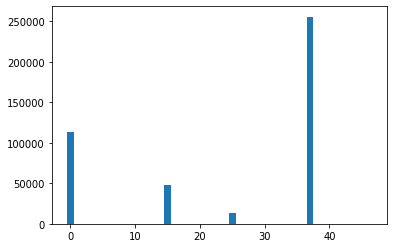

In [580]:
plt.hist(df_results['action'], bins = [- 0.5 + x for x in range(48)])

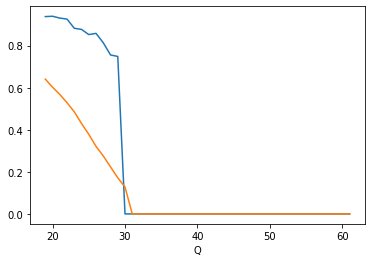

In [581]:
df_results.groupby('Q')['E_prob'].mean().plot()
df_results.groupby('Q')['E'].mean().plot()

In [582]:
df_results['K_plus'] = df_results['K'].shift(-1)
df_results['K_plus_20'] = df_results['K'].shift(-20)

In [583]:

kids1 = set(df_results.loc[(df_results['K'] == 0) & \
            (df_results['K_plus'] == 1) & (df_results['Q'] == 30) & (df_results['K_plus_20'] == 1)]['episode'])
kids0 = set(df_results.loc[(df_results['K_plus'] == 0) & (df_results['Q'] == 30) & (df_results['K_plus_20'] == 0)]['episode'])

In [584]:
df_results.loc[df_results['episode'].isin(kids1)]

,Q,G,K,Z,beta_L,E_prob,E,b1,b2,b3,b4,c1,c2,c3,c4,action,scaled_reward,episode,K_plus,K_plus_20
344,19.0,1.582000,0.0,-3.909660,22.040816,0.938127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11.026600,8.0,0.0,1.0
345,20.0,1.251362,0.0,0.796251,22.040816,0.939794,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.252137,8.0,0.0,1.0
346,21.0,1.395233,0.0,16.106887,22.040816,0.931079,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,-9.695595,8.0,0.0,1.0
347,22.0,1.509035,0.0,12.541087,22.040816,0.926240,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,-9.034414,8.0,0.0,1.0
348,23.0,1.599052,0.0,23.659366,22.040816,0.882539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,-8.359707,8.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427028,57.0,4.779503,1.0,154.095627,22.040816,0.000000,0.0,1.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,37.0,6.433472,9930.0,1.0,1.0
427029,58.0,4.780587,1.0,160.176853,22.040816,0.000000,0.0,1.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,37.0,6.445817,9930.0,1.0,1.0
427030,59.0,4.781444,1.0,153.063348,22.040816,0.000000,0.0,1.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,37.0,6.209198,9930.0,1.0,1.0
427031,60.0,4.782123,1.0,160.112601,22.040816,0.000000,0.0,1.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,37.0,6.229663,9930.0,1.0,1.0


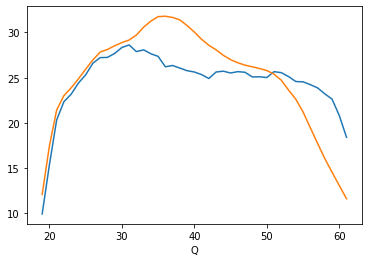

In [585]:
df_results.loc[df_results['episode'].isin(kids1)].groupby('Q')['action'].mean().plot()
df_results.loc[df_results['episode'].isin(kids0)].groupby('Q')['action'].mean().plot()

In [586]:
df_infos = pd.DataFrame(infos)

In [587]:
df_big = pd.concat([df_results, df_infos.drop('Q', axis=1)], axis=1)

In [588]:
df_big['L_plus'] = df_big['L'].shift(-1)
df_big['E_plus'] = df_big['E'].shift(-1)
df_big['action_plus'] = df_big['action'].shift(-1)

In [589]:
df_big['educ_change'] = df_big.apply(lambda row: no_more_educ(row['E'], row['E_plus'], row['Q']), axis=1)

In [590]:
def no_more_educ(E, E_plus, Q):
    if E != E_plus and Q < 45:
        return 1
    else:
        return 0

In [591]:
np.mean(df_big.loc[df_big['educ_change'] == 1][['Q', 'action', 'action_plus']])

Q              25.415289
action         13.171139
action_plus    15.248830
dtype: float64

In [592]:
np.mean(df_big.loc[(df_big['educ_change'] == 0) & (df_big['Q'] < 34)][['Q', 'action', 'action_plus']])

Q              26.026102
action         24.496030
action_plus    25.477840
dtype: float64

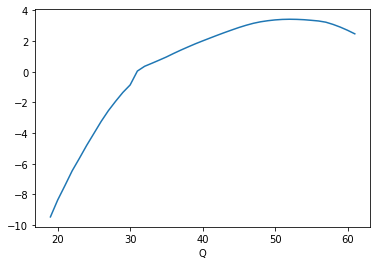

In [593]:
df_big.groupby('Q').mean()['scaled_reward'].plot()

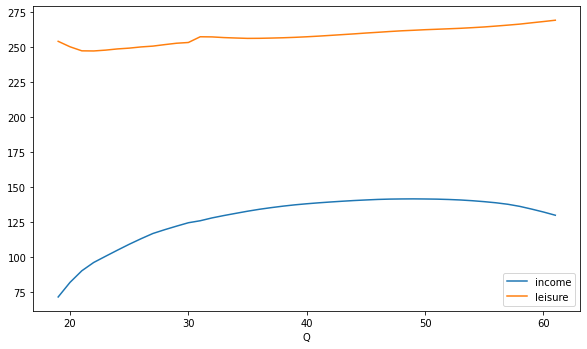

In [594]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
np.sqrt(df_big.groupby('Q').mean()['Y']).plot(label='income')
(beta_L*np.sqrt(df_big.groupby('Q').mean()['L'])).plot(label='leisure')
ax.legend()

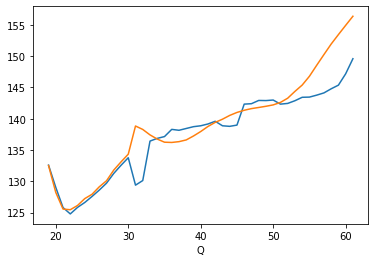

In [595]:
df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['L'].mean().plot()
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['L'].mean().plot()

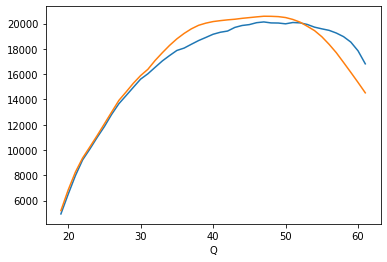

In [596]:
df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['Y'].mean().plot()
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['Y'].mean().plot()

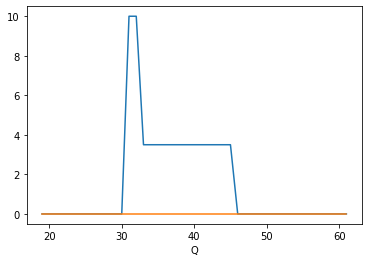

In [597]:
df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['J'].mean().plot()
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['J'].mean().plot()

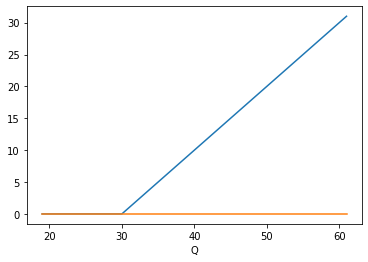

In [598]:
df_big.loc[df_big['episode'].isin(kids1)].groupby('Q')['c1'].mean().plot()
df_big.loc[df_big['episode'].isin(kids0)].groupby('Q')['c1'].mean().plot()

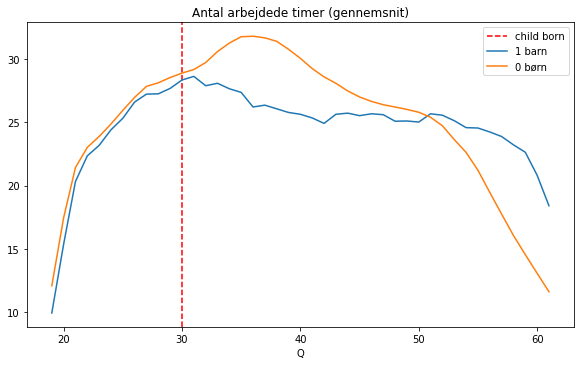

In [599]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Antal arbejdede timer (gennemsnit)")
ax.axvline(x=30, label='child born', ls='--', color='red')

df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['action'].mean().plot(label='1 barn')
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['action'].mean().plot(label='0 børn')

ax.legend()

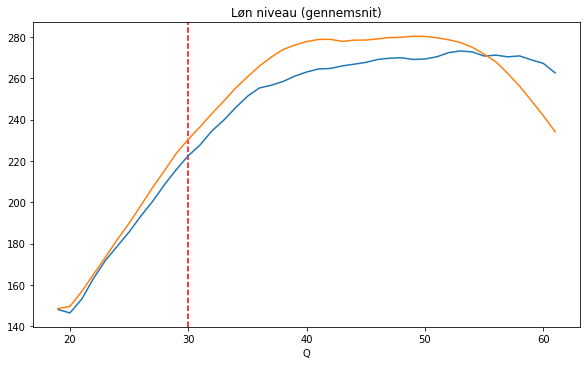

In [600]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Løn niveau (gennemsnit)")
ax.axvline(x=30, label='child born', ls='--', color='red')

df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['S'].mean().plot(label='1 barn')
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['S'].mean().plot(label='0 børn')

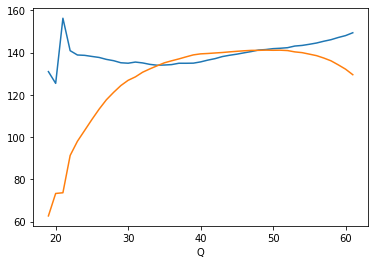

In [603]:
educ_end_23 = set(df_big.loc[(df_big['educ_change']==1) & (df_big['Q'] == 20)]['episode'])
df_big.loc[df_results['episode'].isin(educ_end_23)].groupby('Q')['L'].mean().plot()

educ_end_23 = set(df_big.loc[(df_big['educ_change']==1) & (df_big['Q'] == 20)]['episode'])
np.sqrt(df_big.loc[df_results['episode'].isin(educ_end_23)].groupby('Q')['Y'].mean()).plot()

In [602]:
df_big['beta_L']

0         22.040816
1         22.040816
2         22.040816
3         22.040816
4         22.040816
            ...    
429995    22.040816
429996    22.040816
429997    22.040816
429998    22.040816
429999    22.040816
Name: beta_L, Length: 430000, dtype: float64